# HW1
### Olivia Li
This solution includes the following:
- Data Analysis
- Parameter Tuning and Model Selection
- Optimal Model Fitting and Result Analysis

# 0. Import and Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta,AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
import random
import scipy.stats
from sklearn.mixture import GaussianMixture
import torch
from torch.distributions import constraints

In [2]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    guide = AutoDelta(poutine.block(model, expose = ['weight', 'locs', 'scales']),
                     init_loc_fn = init_loc_fn )
    svi = SVI(model, guide, optim, loss = elbo)
    return guide, svi, svi.loss(model, guide, data)

In [16]:
def estimated_density(x):
    return np.sum([scipy.stats.norm(loc=mu, scale=sigma2).pdf(x) * pi \
                   for mu, sigma2, pi in zip(locs.detach().numpy(), \
                                            scales.detach().numpy(), \
                                            weights.detach().numpy())])

# 1. Data Preparation, Histogram & KDE
Kernel Density Estimation (KDE) is a non-parametric statistical technique used for estimating the probability density function (PDF) of a continuous random variable. KDE of given dataset is shown below.

In [3]:
df = pd.read_pickle(r'data_set 1.zip')

In [4]:
df.head()

,data
0,0.205676
1,0.575321
2,1.346189
3,-2.107491
4,0.237493


In [5]:
data_np = df['data'].to_numpy().reshape(-1, 1)

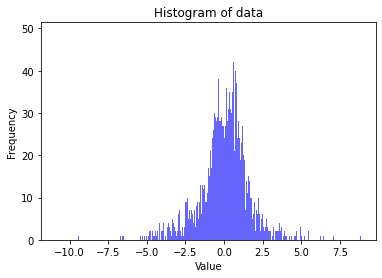

In [6]:
plt.hist(df['data'], bins=4000, color='blue', alpha=0.6)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of data')
plt.show()

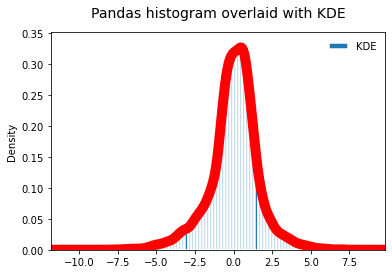

In [7]:
#this code displays the histogram of the data set with a smooth curve overlaid
import seaborn as sns

ax = df['data'].plot.hist(bins=100, density=True, edgecolor='w', linewidth=2.5)

# Save default x-axis limits for final formatting because the pandas kde
# plot uses much wider limits which usually decreases readability
xlim = ax.get_xlim()

# Plot pandas KDE
df['data'].plot.density(color='r', linewidth = 10,alpha=1, ax=ax) # same as df['var'].plot.kde()

# Reset x-axis limits and edit legend and add title
ax.set_xlim(xlim)
ax.legend(labels=['KDE'], frameon=False)
ax.set_title('Pandas histogram overlaid with KDE', fontsize=14, pad=15)

plt.show()

## 2. Parameter Selection

Here we use BIC as the metrix to evaluate the performance of the model. We choose BIC because it aims to balance model **fit** and model **complexity** by penalizing models with a higher number of parameters.

In [8]:
# Initialize a list to store BIC scores
bic_scores = []

n_range = range(2, 11)
# Loop through different values of n_components
for n in n_range:
    gmm = GaussianMixture(n_components = n,
                     covariance_type = 'full',
                     tol = 0.001,
                     reg_covar = 1e-06,
                     max_iter = 700,
                     n_init = 1,
                     init_params = 'kmeans')
    gmm.fit(data_np)  # Fit the GMM to your data
    bic_scores.append(gmm.bic(data_np))  # Calculate and store the BIC score

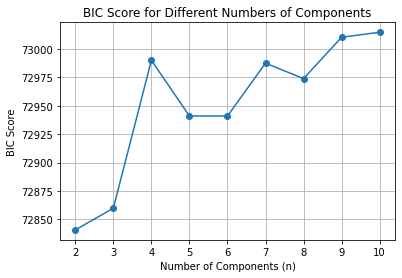

The best number of components is 1 with a BIC score of 72840.71935645101


In [9]:
# Plot the BIC scores
plt.plot(n_range, bic_scores, marker='o')
plt.xlabel("Number of Components (n)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Different Numbers of Components")
plt.grid(True)
plt.show()

# Find the best number of components based on the lowest BIC score
best_n_components = np.argmin(bic_scores) + 1
print(f"The best number of components is {best_n_components} with a BIC score of {bic_scores[best_n_components - 1]}")


In [10]:
# Initialize a list to store BIC scores
bic_scores_ = []

n_range = range(2, 11)
# Loop through different values of n_components
for n in n_range:
    gmm = GaussianMixture(n_components = n,
                     covariance_type = 'spherical',
                     tol = 1e-06,
                     max_iter = 1000)
    gmm.fit(data_np)  # Fit the GMM to your data
    bic_scores_.append(gmm.bic(data_np))  # Calculate and store the BIC score

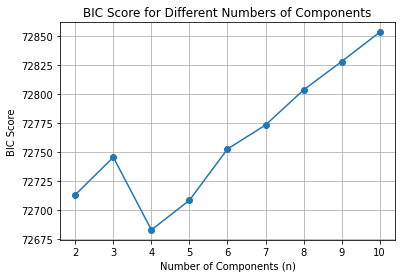

The best number of components is 3 with a BIC score of 72683.18334978753


In [11]:
# Plot the BIC scores
plt.plot(n_range, bic_scores_, marker='o')
plt.xlabel("Number of Components (n)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Different Numbers of Components")
plt.grid(True)
plt.show()

# Find the best number of components based on the lowest BIC score
best_n_components = np.argmin(bic_scores_) + 1
print(f"The best number of components is {best_n_components} with a BIC score of {bic_scores_[best_n_components - 1]}")


# 3. Optimal Model Fitting

We conclude that **K = 4** is the optimal parameter.

In the following code, we plot the **histogram** of data, the **KDE** probability plot of given dataset, and the **predicted probability of fitted model**.

We conclude that the fitted model matches with the real dataset.

In [18]:
data = torch.tensor(df.values.ravel().tolist())

In [19]:
data.shape

torch.Size([20000])

In [20]:
# we first have to define the pyro model. We first specify the prior. There are three groups of parameters: the weights i.e.
# the distribution over {0,1,2}, the means for each of the tree Gaussians and their variances. These are all independent so
# the prior is a product of the distributions over each parameter
K=4

@config_enumerate
def model(data):
    samples = []
    # the distribution pi is sampled from a Dirichlet distribution. The Dirichlet is a distribution over the
    # probability simplex i.e. all vectors $x_1,x_2,...,x_n$ with x_i > 0 and summing up to 1
    # each of the parameters are stored in the pyro.param_store as items in a dict, as we can see they all have to be named.
    # In pyro distributions are basically characterized by their samples
    weights=pyro.sample('weights',dist.Dirichlet(0.5*torch.ones(K)))
    
    #the pyro.plate specifies an array of independent distributions. Here the distribution for each of the means is a
    #Gaussian with mean 0 and variance 10, the variances have a LogNormal distribution since the have to be > 0.
    # these distributions are stored in an array in the param_store named 'components'
    with pyro.plate('components',K):
        #the prior distriburion of the means
        locs = pyro.sample('locs',dist.Normal(0.,10.))
        # the prior distribution of the variances
        scales = pyro.sample('scales',dist.LogNormal(0.,2.))
        
    #here is the likelihood, for each data point an assignment to a Gaussian and then it is a sample from that Gaussian
    # first a sample from the distribution pi, which in turn is a sample from the Dirichlet distribution above.
    # then a sample from the corresponding Gaussian with mean and variance sampled from the appropriate priors
    with pyro.plate('data',len(data)):
        assignment = pyro.sample('assignment',dist.Categorical(weights))
        pyro.sample('obs',dist.Normal(locs[assignment],scales[assignment]),obs=data)
        

In [21]:
optim = pyro.optim.Adam({'lr':0.01,'betas':[0.8,0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [22]:
#Here we initialize the values, the 'weights' = [1/3,1/3,1/3], the 'scales = variances' = [1,1,1]
# and the 'locs=means' = randomly chosen from the data with equal probability
def init_loc_fn(site):
    if site['name'] == 'weights':
        return torch.ones(K)/K
    if site['name'] == 'scales':
        return torch.ones(K)
    if site['name'] == 'locs':
        return data[torch.multinomial(torch.ones(len(data))/len(data),K)]
    raise ValueError(site['name'])

In [23]:
pyro.set_rng_seed(0) #this initializes the random number generator
pyro.clear_param_store() #This clears out any previous values that might still be stored
    
guide = AutoDelta(poutine.block(model,expose=['weights','locs','scales']),init_loc_fn =  init_loc_fn )
#Here we define the Variational Distribution as a DElta function. The initial parameters are set
#by the init_loc_fn function

svi = SVI(model,guide,optim,loss=elbo)
#This is the object that takes care of all the inference and does stochastic variational inference
#to find the optimal parameters (i.e. maximizing the ElBO)

In [24]:
#Here we run the training loop, the svi object takes care of computing the Monte Carlo gradient
#and updating the parameters at each step
losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if i % 10 == 0:
        print(loss)

46839.6484375
43635.03515625
41419.1640625
39747.78515625
38587.1484375
37837.125
37368.0703125
37068.84765625
36868.44921875
36728.44140625
36628.09765625
36555.41796875
36502.58984375
36464.11328125
36435.9375
36415.078125
36399.5078125
36387.80078125
36378.9375
36372.23046875
36367.16015625
36363.3359375
36360.453125
36358.27734375
36356.6875
36355.47265625
36354.578125
36353.91796875
36353.40625
36352.9921875
36352.68359375
36352.3984375
36352.13671875
36351.91796875
36351.69140625
36351.46484375
36351.22265625
36350.984375
36350.734375
36350.48046875
36350.21875
36349.95703125
36349.69140625
36349.40234375
36349.10546875
36348.81640625
36348.48828125
36348.1875
36347.84765625
36347.51953125
36347.18359375
36346.84375
36346.49609375
36346.1484375
36345.76171875
36345.41796875
36345.05078125
36344.6796875
36344.3125
36343.953125
36343.5625
36343.18359375
36342.78125
36342.39453125
36341.98046875
36341.5625
36341.1015625
36340.65234375
36340.16796875
36339.6328125
36339.08203125
3633

Text(0.5, 1.0, 'Convergence of SVI')

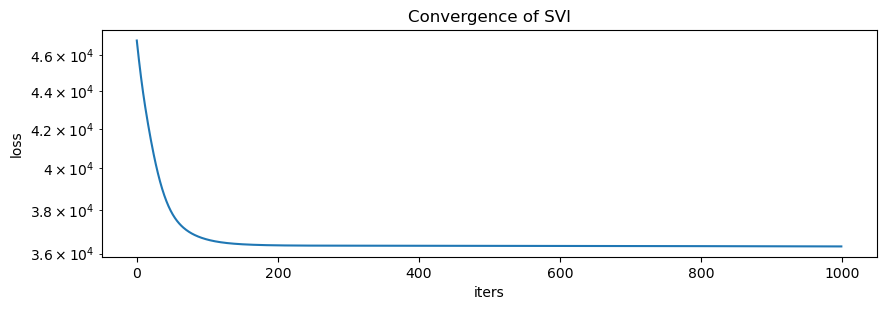

In [25]:
plt.figure(figsize=(10,3),dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')

In [26]:
map_estimates = guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scales = map_estimates['scales']
print('weights ={}'.format(weights.data.numpy()))
print('locs={}'.format(locs.data.numpy()))
print('scales = {}'.format(scales.data.numpy()))

weights =[0.06863144 0.29540643 0.45017785 0.1857842 ]
locs=[ 0.2660426   0.6579813  -0.24388473 -0.39324528]
scales = [1.224847   0.5341074  2.1821737  0.43606165]


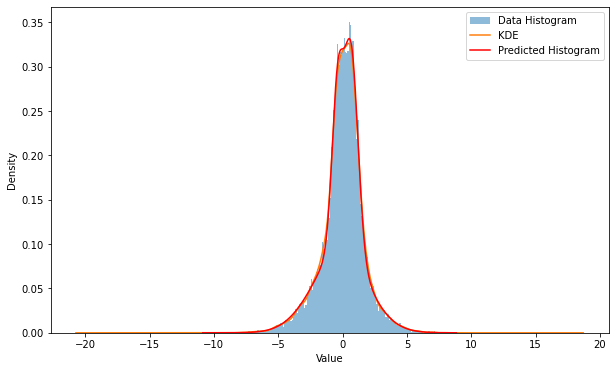

In [31]:
# Assuming you have a DataFrame named data_df with your data
# Extract data from the DataFrame
data = df['data'].values  # Replace 'column_name_containing_data' with the actual column name

# Parameters for the predicted histogram
x_values = np.linspace(data.min(), data.max(), 1000)  # Adjust the number of points as needed
predicted_density = [estimated_density(x) for x in x_values]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the histogram of the data
plt.hist(data, bins=200, density=True, alpha=0.5, label='Data Histogram')
df.data.plot.density(label='KDE')
# Plot the predicted histogram
plt.plot(x_values, predicted_density, label='Predicted Histogram', color='red')

# Add labels and a legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()